In [1]:
# Parameters
notebook_fname = "NN_full_v3_BO_test_9"
data_path = '../01_Dataset_Cleaned/'
model_path = '../04_Model_Saved/'

# Development mode: automatic reloading of modules
%load_ext autoreload
%autoreload 2


# main notebook to train and evaluate the machine learning model


In [2]:
import os
import sys
sys.path.append("..")
sys.path.append("../..")

current_directory = os.getcwd()
print("Current directory:", current_directory)


Current directory: /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/03_Model_Train_Evaluate_Predict


In [3]:
# basic machine learning libaries
import os
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

# Data processing and plotting
import numpy as np
from numpy import asarray
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from tabulate import tabulate

# Bayesian Optimization
import GPyOpt

# Parellisation
from multiprocessing import Pool
from joblib import Parallel, delayed
import concurrent.futures

# Miscellaneous
import importlib
import pickle
import time
import warnings
warnings.filterwarnings("ignore")
# Turn off TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

print(f'cpu_count: {os.cpu_count()}')

# Data Path
if os.path.isfile(data_path+'LiteratureDataset_Corrosion_YW_v3_processed.xlsx'):
    print(f"Folder '{os.path.abspath(data_path)}' found.")
else:
    print(f"Warning: File '{data_path}' not found!")

# Setting up multiple path for parallel Bayesian Optimization
num_str = notebook_fname.split("_")[-1]  # get the last string after "_"

try:
    bo_ens_num = int(num_str)
    print(f"bo_ens_num: {bo_ens_num}")
except ValueError:
    # if the string can't be converted to an integer, keep it as a string
    bo_ens_num = int(123)
    print(f"book master - bo_ens_num: {bo_ens_num}")

# model path
model_path_bo = f'{model_path}{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{os.path.abspath(model_path_bo)}' created.")
else:
    print(f"Folder '{os.path.abspath(model_path_bo)}' already exists.")

# Cleaning up previous tensorflow sessions
tf.keras.backend.clear_session()


2023-09-20 14:40:11.565970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 14:40:14.378135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-20 14:40:14.379104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-20 14:40:14.379134: W tens

cpu_count: 40
Folder '/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/01_Dataset_Cleaned' found.
bo_ens_num: 9
Folder '/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/04_Model_Saved/NN_full_v3_BO_test_9' already exists.


## functionality control


In [4]:
# functionality control of the notebook
Flag_Preprocessing = True
Flag_Training_try = False
Flag_BO_search = False
Flag_Training_BO_best = False
Flag_Evaluation = False
Flag_Prediction = False
Flag_Explainer = True

# Use GPU or not
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print('not using GPU')


not using GPU


## Import hardness and corrosion dataset


In [5]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C',
                             'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm',
                                'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets
df_H = pd.read_excel(
    data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(
    data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output = df_H[compo_column], pd.DataFrame(), df_H[
    specific_features_sel_column],  df_H[H_output_column]
(df_C_compo, df_C_specific_testing, df_C_specific_features,
 df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat(
    [df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat(
    [df_C_compo, df_C_specific_features], axis=1)


## Data preprocessing

**hardness network**

- input (X1): df_H_compo
- input (Y1): df_H_specific_testing
- input (V1): df_H_specific_features
- output(H1): df_H_output

**corrosion network**

- input (X2): df_C_compo
- input (Z2): df_C_specific_testing
- input (W2): df_C_specific_features
- output(C2): df_C_output

### Obtain the MinMaxScaler from normalisation


In [6]:
if Flag_Preprocessing:

    # Prepare data for NN
    dfs = [df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output,
           df_C_compo, df_C_specific_testing, df_C_specific_features, df_C_output]

    # Convert DataFrames to numpy arrays
    inputs_outputs = [np.asarray(df.values) for df in dfs]

    # Define each variable
    (X1, Y1, V1, H1,
     X2, Z2, W2, C2) = inputs_outputs

    # Initialize MinMaxScalers for each data set
    scalers = {
        "compo": MinMaxScaler(),
        "H_specific_testing": MinMaxScaler(),
        "C_specific_testing": MinMaxScaler(),
        "specific_features": MinMaxScaler(),
        "H_output": MinMaxScaler(),
        "C_output": MinMaxScaler()
    }

    # Fit scalers to appropriate data
    scalers["compo"].fit(np.concatenate((X1, X2)))
    if Y1.size != 0:  # if Y1 is empty
        scalers["H_specific_testing"].fit(Y1)
    scalers["C_specific_testing"].fit(Z2)
    scalers["specific_features"].fit(np.concatenate((V1, W2)))
    scalers["H_output"].fit(H1.reshape((-1, 1)))
    scalers["C_output"].fit(C2.reshape((-1, 1)))

    # Save the scalers dictionary to a file using pickle
    with open(data_path + 'scalers.pkl', 'wb') as f:
        pickle.dump(scalers, f)

    print(scalers)

{'compo': MinMaxScaler(), 'H_specific_testing': MinMaxScaler(), 'C_specific_testing': MinMaxScaler(), 'specific_features': MinMaxScaler(), 'H_output': MinMaxScaler(), 'C_output': MinMaxScaler()}


### RepeatedKFold train-test split

- for hardness: `kfold_with_norm_H`

  - `X1_train_KFold`, `X1_test_KFold`,
  - (empty array)
  - `V1_train_KFold`, `V1_test_KFold`,
  - `H1_train_KFold`, `H1_test_KFold` as lists used in model training

- for corrosion: `kfold_with_norm_C`
  - `X2_train_KFold`, `X2_test_KFold`,
  - `Z2_train_KFold`, `Z2_test_KFold`,
  - `W2_train_KFold`, `W2_test_KFold`,
  - `C2_train_KFold`, `C2_test_KFold` as lists used in model training


In [7]:
if Flag_Preprocessing:

    from utils.preprocessing_kfold_norm import kfold_with_norm

    n_splits, n_repeats, random_state = 6, 2, 42

    # for hardness network
    ([X1_train_KFold, Y1_train_KFold, V1_train_KFold, H1_train_KFold],
     [X1_test_KFold, Y1_test_KFold, V1_test_KFold, H1_test_KFold],
     [X1_train_norm_KFold, Y1_train_norm_KFold,
         V1_train_norm_KFold, H1_train_norm_KFold],
     [X1_test_norm_KFold, Y1_test_norm_KFold, V1_test_norm_KFold, H1_test_norm_KFold]) = kfold_with_norm(X1, Y1, V1, H1,
                                                                                                         scalers["compo"], scalers["H_specific_testing"], scalers[
                                                                                                             "specific_features"], scalers["H_output"],
                                                                                                         n_splits, n_repeats, random_state)

    # for corrosion network
    ([X2_train_KFold, Z2_train_KFold, W2_train_KFold, C2_train_KFold],
     [X2_test_KFold, Z2_test_KFold, W2_test_KFold, C2_test_KFold],
     [X2_train_norm_KFold, Z2_train_norm_KFold,
         W2_train_norm_KFold, C2_train_norm_KFold],
     [X2_test_norm_KFold, Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold]) = kfold_with_norm(X2, Z2, W2, C2,
                                                                                                         scalers["compo"], scalers["C_specific_testing"], scalers[
                                                                                                             "specific_features"], scalers["C_output"],
                                                                                                         n_splits, n_repeats, random_state)


### Plot the histogram of train/test data for each split

- Plotting hardness train/test datasets
- Plotting corrosion train/test datasets


In [8]:
# if Flag_Preprocessing:

#     from utils.preprocessing_kfold_norm import plot_hist_kfold_with_norm

#     # call the function to plot the histograms - hardness network
#     plot_hist_kfold_with_norm(train_data=(X1_train_norm_KFold, Y1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold),
#                               test_data=(X1_test_norm_KFold, Y1_test_norm_KFold, V1_test_norm_KFold,  H1_test_norm_KFold),
#                               x_min=(0, 0, 0, 0),
#                               x_max=(0.2, 0, 1, 1),
#                               axs_title='Hardness network Train/Test Data',
#                               n_splits=6, n_repeats=1, nrows=4)

#     # call the function to plot the histograms - corrosion network
#     plot_hist_kfold_with_norm(train_data=(X2_train_norm_KFold, Z2_train_norm_KFold, W2_train_norm_KFold, C2_train_norm_KFold),
#                               test_data=(X2_test_norm_KFold,  Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold),
#                               x_min=(0, 0, 0, 0),
#                               x_max=(0.2, 1, 1, 1),
#                               axs_title='Corrosion network Train/Test Data',
#                               n_splits=6, n_repeats=1, nrows=4)


## NN architecture, creation, evaluation:

- shared feature NN: NNS
- hardness NN: NNH
- corrosion NN: NNC

class: `MultiTaskNN`

```
         input2-->|
                  |-->[NNH]-->output_H
                  |
 input1-->[NNS]-->|
                  |
                  |-->[NNC]-->output_C
         input3-->|
```


### Using `MultiTaskNN` class for training


In [9]:
if Flag_Training_try:

    from utils.multitask_nn import MultiTaskNN

    start_time = time.time()
    mt_nn = MultiTaskNN(NNS_num_nodes=256, NNS_num_layers=1,
                        NNH_num_nodes=64, NNH_num_layers=4,
                        NNC_num_nodes=64, NNC_num_layers=3,
                        mc_state=True, act='relu',
                        NNS_dropout=0.25, NNH_dropout=0.25, NNC_dropout=0.25,
                        loss_func=tf.keras.metrics.mean_squared_error,
                        learning_rate_H=0.001, learning_rate_C=0.001,
                        batch_size_H=32,
                        N_epochs_local=1,
                        total_epochs=10,
                        model_save_flag=True, model_path_bo=model_path_bo,
                        NNH_model_name='NNH_model_RepeatedKFold_{}',
                        NNC_model_name='NNC_model_RepeatedKFold_{}')

    # inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    # train_loss/val_loss: training/validation loss history
    # score_loss/score_r2: evaluated loss score/R2 score

    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                               X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                               k_folds, n_CVrepeats)

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


### Training quality for NNH_model and NNC_model


In [10]:
if Flag_Training_try:
    # training results by score_loss
    # print([f'{x:.4f}' for x in score_loss_H])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_H[i][-1]])
    print(
        f"score_loss_H: {np.mean(score_loss_H):.4f} ({np.std(score_loss_H):.4f})")

    # print([f'{x:.4f}' for x in score_loss_C])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_C[i][-1]])
    print(
        f"score_loss_C: {np.mean(score_loss_C):.4f} ({np.std(score_loss_C):.4f})")

    # training results by score_r2
    # print([f'{x:.4f}' for x in score_r2_H])
    print(
        f"score_r2_H:   {np.mean(score_r2_H):.4f} ({np.std(score_r2_H):.4f})")

    # print([f'{x:.4f}' for x in score_r2_C])
    print(f"score_r2_C: {np.mean(score_r2_C):.4f} ({np.std(score_r2_C):.4f})")

    print(f"score_r2_HC: {np.mean([score_r2_H, score_r2_C]):.4f}")


### Plot the loss history


In [11]:
if Flag_Training_try:
    mt_nn.plot_losses(train_loss_H, val_loss_H,
                      train_loss_C, val_loss_C, k_folds=6, n_CVrepeats=2, index=0)


## Bayesian Hyperparameter Optimisation

class: `BO_hyper_objective`


### Define the search domain


In [12]:
if Flag_BO_search:
    # Define the search space for hyperparameters

    # loss_encoder == 0: mean_squared_error
    # loss_encoder == 1: mean_absolute_error

    search_hyper_space = [{'name': 'NNS_num_nodes',   'type': 'discrete',  'domain': (32, 64, 128, 256)},  # 0: NNS_num_nodes
                          {'name': 'NNS_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3, 4, 5)},  # 1: NNS_num_layers
                          {'name': 'NNH_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 2: NNH_num_nodes
                          {'name': 'NNH_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 3: NNH_num_layers
                          {'name': 'NNC_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 4: NNC_num_nodes
                          {'name': 'NNC_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 5: NNC_num_layers
                          {'name': 'learning_rate_H', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 9: learning_rate_H
                          {'name': 'learning_rate_C', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 10: learning_rate_C
                          {'name': 'batch_size_H',    'type': 'discrete',
                           'domain': (16, 32, 64)},        # 11: batch_size_H
                          {'name': 'N_epochs_local',  'type': 'discrete',  'domain': (1, 2, 3)}]  # 12: N_epochs_global

    fixed_hyper_space = [{'name': 'NNS_dropout',     'type': 'continuous',
                          'domain': (0.1)},            # 6: NNS_dropout
                         {'name': 'NNH_NNC_dropout', 'type': 'continuous',
                          'domain': (0.1)},            # 7: NNH_NNC_dropout
                         {'name': 'loss_encoder',      'type': 'discrete',
                          'domain': (0)}]               # 8: loss_encoder

    search_hyper_names = [entry['name'] for entry in search_hyper_space]
    fixed_hyper_names = [entry['name'] for entry in fixed_hyper_space]
    all_hyper_names = ['NNS_num_nodes', 'NNS_num_layers', 'NNH_num_nodes', 'NNH_num_layers', 'NNC_num_nodes', 'NNC_num_layers',
                       'NNS_dropout', 'NNH_NNC_dropout',  'loss_encoder', 'learning_rate_H',  'learning_rate_C',   'batch_size_H', 'N_epochs_local']


### BO hyperparameter optimisation


In [13]:
if Flag_BO_search:
    from utils.BO_hyper_objective import BayesianOptimizationObjective

    start_time = time.time()

    # Set up the optimizer
    bo = None
    bo_iteration = 0
    np.random.seed(bo_ens_num)

    # Configuration settings for the model being optimized
    total_epochs = 1000
    n_initial_points, n_iterations = 10, 200

    mc_state, act = True, 'relu'
    model_save_flag = False
    NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}', 'NNC_model_RepeatedKFold_{}'
    k_folds, n_CVrepeats = 6, 2
    score_r2_HC_list, score_loss_HC_list, score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list = [], [], [], [], [], []

    # Instantiate the objective function class for Bayesian Optimization
    bo_obj = BayesianOptimizationObjective(
        bo_ens_num, model_path_bo, all_hyper_names, search_hyper_names)

    # Set up and configure Bayesian Optimization using GPyOpt
    bo = GPyOpt.methods.BayesianOptimization(f=lambda x: bo_obj.BO_NNS_NNH_NNC_objective(x, fixed_hyper_space, search_hyper_names, fixed_hyper_names,
                                                                                         n_initial_points, n_iterations,
                                                                                         mc_state, act,
                                                                                         total_epochs,
                                                                                         model_save_flag, model_path_bo,
                                                                                         NNH_model_name, NNC_model_name,
                                                                                         X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                                         X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                                         k_folds, n_CVrepeats,
                                                                                         score_r2_HC_list, score_loss_HC_list,
                                                                                         score_r2_H_list, score_r2_C_list,
                                                                                         score_loss_H_list, score_loss_C_list)[0],  # Use only score_r2 as objective function
                                             domain=search_hyper_space,
                                             model_type='GP',
                                             initial_design_numdata=n_initial_points,
                                             init_design_type='random',
                                             acquisition_type='EI',
                                             acquisition_optimizer_type='lbfgs',
                                             maximize=True)

    # Start the optimization for the given number of iterations
    bo.run_optimization(max_iter=n_iterations)

    # Print the best hyperparameters and their corresponding objective value
    best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
    print("Best hyperparameters: {}".format(best_hyperparameters))
    print("Best objective value:", -bo.fx_opt)

    # Calculate and display the elapsed time for the optimization
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


### Save the BO hypertable


In [14]:
if Flag_BO_search:

    # update the hypertable
    bo_obj.update_hypertable(fixed_hyper_space, bo,
                             score_r2_HC_list, score_loss_HC_list,
                             score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list)

    # Save the sorted data to an Excel file
    bo_obj.hypertable.to_excel(model_path_bo +
                               f"hypertable_{notebook_fname}.xlsx", index=False)

    # sort the list start from the best results
    hypertable_sort = bo_obj.hypertable.sort_values(
        by=['score_r2_HC'], ascending=False, ignore_index=True)

    display(hypertable_sort.head())

    # Save the sorted data to an Excel file
    hypertable_sort.to_excel(model_path_bo +
                             f"hypertable_sort_{notebook_fname}.xlsx", index=False)


### Plotting the BO process


In [15]:
if Flag_BO_search:
    # plot the convergence
    bo.plot_convergence()

    bo_obj.plot_best_r2_score()


## Model training: using best BO hyperparameters


In [16]:
if Flag_Training_BO_best:

    import tensorflow as tf
    import pandas as pd
    from utils.multitask_nn import MultiTaskNN

    def get_hyperparameter(param_name, hypertable):
        return hypertable.loc[0, param_name]

    def create_multi_task_nn(mc_state, act, total_epochs,
                             NNH_model_name, NNC_model_name, hypertable):
        # Define loss encoders
        loss_encoders = {
            0: tf.keras.metrics.mean_squared_error,
            1: tf.keras.metrics.mean_absolute_error
        }
        loss_encoder = int(get_hyperparameter('loss_encoder', hypertable))
        loss_func = loss_encoders.get(loss_encoder)
        if not loss_func:
            raise ValueError(f"Invalid loss function '{loss_encoder}' ")

        # Define parameters
        params = {
            'NNS_num_nodes': int(get_hyperparameter('NNS_num_nodes', hypertable)),
            'NNS_num_layers': int(get_hyperparameter('NNS_num_layers', hypertable)),
            'NNH_num_nodes': int(get_hyperparameter('NNH_num_nodes', hypertable)),
            'NNH_num_layers': int(get_hyperparameter('NNH_num_layers', hypertable)),
            'NNC_num_nodes': int(get_hyperparameter('NNC_num_nodes', hypertable)),
            'NNC_num_layers': int(get_hyperparameter('NNC_num_layers', hypertable)),
            'mc_state': mc_state,
            'act': act,
            'NNS_dropout': get_hyperparameter('NNS_dropout', hypertable),
            'NNH_dropout': get_hyperparameter('NNH_NNC_dropout', hypertable),
            'NNC_dropout': get_hyperparameter('NNH_NNC_dropout', hypertable),
            'loss_func': loss_func,
            'learning_rate_H': get_hyperparameter('learning_rate_H', hypertable),
            'learning_rate_C': get_hyperparameter('learning_rate_C', hypertable),
            'batch_size_H': int(get_hyperparameter('batch_size_H', hypertable)),
            'N_epochs_local': int(get_hyperparameter('N_epochs_local', hypertable)),
            'total_epochs': total_epochs,
            'model_save_flag': True,
            'model_path_bo': model_path_bo,
            'NNH_model_name': NNH_model_name,
            'NNC_model_name': NNC_model_name
        }

        return MultiTaskNN(**params)


In [17]:
if Flag_Training_BO_best:

    start_time = time.time()

    # ---------- loading the best BO hyperparameters ----------
    hypertable_sort = pd.read_excel(
        model_path_bo + f"hypertable_sort_{notebook_fname}.xlsx")
    hypertable_BObest = hypertable_sort.head(1)
    display(hypertable_BObest)
    k_folds, n_CVrepeats = 6, 2

    # ---------- creating models ----------
    # BEST MODEL with MC dropout for uncertained quantification
    mt_nn_BObest_mc = create_multi_task_nn(mc_state=True, act='relu', total_epochs=5000,
                                           NNH_model_name='NNH_model_RepeatedKFold_{}_{act}',
                                           NNC_model_name='NNC_model_RepeatedKFold_{}_{act}',
                                           hypertable=hypertable_BObest)

    # BEST MODEL without MC dropout for Shap.deepExlainer (no special layer for calculation speed)
    mt_nn_BObest = create_multi_task_nn(mc_state=False, act='relu', total_epochs=5000,
                                        NNH_model_name='NNH_model_RepeatedKFold_{}_{act}',
                                        NNC_model_name='NNC_model_RepeatedKFold_{}_{act}',
                                        hypertable=hypertable_BObest)

    # Best model with only compositional input to simplify feature interaction analysis
    mt_nn_BObest_lean = create_multi_task_nn(mc_state=False, act='swish', total_epochs=5000,
                                             NNH_model_name='NNH_model_RepeatedKFold_{}_lean_{act}',
                                             NNC_model_name='NNC_model_RepeatedKFold_{}_lean_{act}',
                                             hypertable=hypertable_BObest)

    # Helper function to evaluate the model in standard way
    def evaluate_model(model):
        return model.evaluate_NN_full_model(
            X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
            X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
            k_folds, n_CVrepeats
        )

    # Helper function to evaluate the model, but replace the testing and feature inputs to be empty
    def evaluate_model_lean(model):

        def create_empty_arrays(arr_list):
            return [np.empty((arr.shape[0], 0)) for arr in arr_list]

        datasets = [Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold,
                    Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold]

        Y1_train_empty, Y1_test_empty, V1_train_empty, V1_test_empty, \
            Z2_train_empty, Z2_test_empty, W2_train_empty, W2_test_empty = map(
                create_empty_arrays, datasets)

        return model.evaluate_NN_full_model(
            X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_empty, Y1_test_empty, V1_train_empty, V1_test_empty, H1_train_norm_KFold, H1_test_norm_KFold,
            X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_empty, Z2_test_empty, W2_train_empty, W2_test_empty, C2_train_norm_KFold, C2_test_norm_KFold,
            k_folds, n_CVrepeats)

    # ---------- model training in parallel ----------
    # Using ProcessPoolExecutor to run in parallel
    results = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # futures = [executor.submit(evaluate_model, mt_nn_BObest_mc),
        #            executor.submit(evaluate_model, mt_nn_BObest),
        #            executor.submit(evaluate_model_lean, mt_nn_BObest_lean)]
        futures = [executor.submit(evaluate_model_lean, mt_nn_BObest_lean)]

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            results.append(result)

    # Unpack results as needed
    # (train_loss_H_mc, train_loss_C_mc, val_loss_H_mc,
    #  val_loss_C_mc, _, _, _, _) = results[0]
    # (train_loss_H, train_loss_C, val_loss_H,
    #  val_loss_C, _, _, _, _) = results[1]
    # (train_loss_H_lean, train_loss_C_lean, val_loss_H_lean,
    #  val_loss_C_lean, _, _, _, _) = results[2]

    (train_loss_H_lean, train_loss_C_lean, val_loss_H_lean,
     val_loss_C_lean, _, _, _, _) = results[0]

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


In [18]:
if Flag_Training_BO_best:

    # mt_nn_BObest_mc.plot_losses(train_loss_H_mc, val_loss_H_mc, train_loss_C_mc,
    #                             val_loss_C_mc, k_folds=6, n_CVrepeats=2, index=0)  # index points to bootstrap

    # mt_nn_BObest.plot_losses(train_loss_H, val_loss_H, train_loss_C,
    #                          val_loss_C, k_folds=6, n_CVrepeats=2, index=0)  # index points to bootstrap

    mt_nn_BObest_lean.plot_losses(train_loss_H_lean, val_loss_H_lean, train_loss_C_lean,
                                  val_loss_C_lean, k_folds=6, n_CVrepeats=2, index=0)  # index points to bootstrap

## Evaluate the training results

- Show the model.h5 files in this directory
- Load scalers


In [19]:
import pickle
from utils.postprocessing_evalutation import display_saved_models

print(os.path.abspath(model_path_bo))

NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_', 'NNC_model_RepeatedKFold_'

display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name, mc_state=True, islean=False, act='relu')
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name, mc_state=False, islean=False, act='relu')
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name, mc_state=False, islean=True, act='swish')

# Load the scalers dictionary from a file using pickle
with open(data_path + 'scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    print("")
print(scalers)


/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/04_Model_Saved/NN_full_v3_BO_test_9

NNH_model_mc                           NNC_model_mc
-------------------------------------  -------------------------------------
NNH_model_RepeatedKFold_1_mc_relu.h5   NNC_model_RepeatedKFold_1_mc_relu.h5
NNH_model_RepeatedKFold_2_mc_relu.h5   NNC_model_RepeatedKFold_2_mc_relu.h5
NNH_model_RepeatedKFold_3_mc_relu.h5   NNC_model_RepeatedKFold_3_mc_relu.h5
NNH_model_RepeatedKFold_4_mc_relu.h5   NNC_model_RepeatedKFold_4_mc_relu.h5
NNH_model_RepeatedKFold_5_mc_relu.h5   NNC_model_RepeatedKFold_5_mc_relu.h5
NNH_model_RepeatedKFold_6_mc_relu.h5   NNC_model_RepeatedKFold_6_mc_relu.h5
NNH_model_RepeatedKFold_7_mc_relu.h5   NNC_model_RepeatedKFold_7_mc_relu.h5
NNH_model_RepeatedKFold_8_mc_relu.h5   NNC_model_RepeatedKFold_8_mc_relu.h5
NNH_model_RepeatedKFold_9_mc_relu.h5   NNC_model_RepeatedKFold_9_mc_relu.h5
NNH_model_RepeatedKFold_10_mc_relu.h5  NNC_model_RepeatedKF

### prepare for checking NN training quality


In [20]:
if Flag_Evaluation:
    # Define model names for neural networks
    NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}_lean_swish.h5', 'NNC_model_RepeatedKFold_{}_lean_swish.h5'
    is_lean = True

    # Function to create empty arrays based on the shape of input arrays
    def create_empty_arrays(arr_list):
        return [np.empty((arr.shape[0], 0)) for arr in arr_list]

    # Create empty versions of the test datasets
    datasets = [Y1_test_KFold, V1_test_KFold, Z2_test_KFold, W2_test_KFold]
    Y1_test_empty, V1_test_empty, Z2_test_empty, W2_test_empty = map(
        create_empty_arrays, datasets)

    k_folds, n_CVrepeats, mc_repeat = 6, 2, 50

    # Determine datasets based on the is_lean flag
    X1_test_list = X1_test_KFold
    Y1_test_list = Y1_test_empty if is_lean else Y1_test_KFold
    V1_test_list = V1_test_empty if is_lean else V1_test_KFold

    X2_test_list = X2_test_KFold
    Z2_test_list = Z2_test_empty if is_lean else Z2_test_KFold
    W2_test_list = W2_test_empty if is_lean else W2_test_KFold

    repeat_factor = k_folds * n_CVrepeats
    X1_list = [X1] * repeat_factor
    Y1_list = Y1_test_empty if is_lean else [Y1] * repeat_factor
    V1_list = V1_test_empty if is_lean else [V1] * repeat_factor

    X2_list = [X2] * repeat_factor
    Z2_list = Z2_test_empty if is_lean else [Z2] * repeat_factor
    W2_list = W2_test_empty if is_lean else [W2] * repeat_factor


### Plot true vs predictions (test data) for each RepeatedKFold


In [21]:
if Flag_Evaluation:

    from utils.postprocessing_evalutation import predict_bootstrap, plot_test_true_vs_pred

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                  X1_test_list, Y1_test_list, V1_test_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["H_specific_testing"], scalers["specific_features"], scalers["H_output"])

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                  X2_test_list, Z2_test_list, W2_test_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

    H1_test_pred_X1_stack, H1_test_pred_X1_mean, H1_test_pred_X1_std = future1.result()
    C2_test_pred_X2_stack, C2_test_pred_X2_mean, C2_test_pred_X2_std = future2.result()

    plot_test_true_vs_pred(k_folds, n_CVrepeats, H1_test_KFold, H1_test_pred_X1_mean, H1_test_pred_X1_std,
                           [0, 1200], 'NNH', 'firebrick', model_path_bo)

    plot_test_true_vs_pred(k_folds, n_CVrepeats, C2_test_KFold, C2_test_pred_X2_mean, C2_test_pred_X2_std,
                           [-800, 1200], 'NNC', 'steelblue', model_path_bo)


### Plot true vs predictions (full dataset) including all model ensembles


In [22]:
if Flag_Evaluation:

    from utils.postprocessing_evalutation import predict_bootstrap, plot_full_true_vs_pred

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                  X1_list, Y1_list, V1_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["H_specific_testing"], scalers["specific_features"], scalers["H_output"])

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                  X2_list, Z2_list, W2_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

    H1_pred_X1_stack, H1_pred_X1_mean, H1_pred_X1_std = future1.result()
    C2_pred_X2_stack, C2_pred_X2_mean, C2_pred_X2_std = future2.result()

    plot_full_true_vs_pred([H1, C2], [H1_pred_X1_stack, C2_pred_X2_stack],
                           model_path_bo, lims=[[0, 1200], [-800, 1200]])

## Predict based on new data inputs


### Coordinates for PVD alloy representation


In [23]:
if Flag_Prediction:
    # load the wafer-coordinates
    df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
    coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
    coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
    index_PVD_x_y = df_PVD_x_y.index.values+1


### Make predictions for new alloys

- NiCrCoVFe_KW99
- NiCrMoTiFe_KW131


In [24]:
if Flag_Prediction:
    from utils.postprocessing_prediction import prediction_new_composition
    from utils.postprocessing_prediction import plot_prediction_uncertainty, plot_prediction_uncertainty_AVG
    from tqdm import tqdm
    import pandas as pd
    import numpy as np

    # Specify the fname and compo
    compositions = {
        'NiCrCoVFe_KW99': ['Ni', 'Cr', 'Co', 'V', 'Fe'],
        'NiCrMoTiFe_KW131': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
    }

    # Specify the model
    NNH_model_name = 'NNH_model_RepeatedKFold_{}_lean_swish.h5'
    NNC_model_name = 'NNC_model_RepeatedKFold_{}_lean_swish.h5'
    islean = True
    # NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
    # NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'
    # islean = False

    for fname, compo in tqdm(compositions.items(), desc='Processing', total=len(compositions)):

        print(fname, compo)

        # predict for new composition
        (compo_data, H_testing_data, C_testing_data, HC_feature_data,
         H1_new_pred_mean, H1_new_pred_std, C2_new_pred_mean, C2_new_pred_std,
         H1_new_pred_KFold_mean, H1_new_pred_KFold_std,
         C2_new_pred_KFold_mean, C2_new_pred_KFold_std) = prediction_new_composition(fname, compo, data_path, model_path_bo,
                                                                                     NNH_model_name, NNC_model_name, islean, scalers,
                                                                                     specific_features_sel_column=['delta_a', 'Tm', 'sigma_Tm',
                                                                                                                   'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC'],
                                                                                     C_testing=np.array(
                                                                                         [25, 1, 7, 0.333]),
                                                                                     k_folds=6, n_CVrepeats=2, mc_repeat=50)

        # plot NNH predictions
        plot_prediction_uncertainty(
            model_path_bo, coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std,
            pred_label='Hardness', unc_label='Hardness uncertainty',
            title='NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + fname,
            vmin1=100, vmax1=300,
            vmin2=25, vmax2=100)

        # NNC predictions
        plot_prediction_uncertainty(
            model_path_bo, coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std,
            pred_label='Pitting potential (mV)', unc_label='Pitting potential uncertainty (mV)',
            title='NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + fname,
            vmin1=0, vmax1=900,
            vmin2=50, vmax2=150)

        # NNH_NNC_AVG predictions
        plot_prediction_uncertainty_AVG(
            model_path_bo, coord_x, coord_y, index_PVD_x_y,
            H1_new_pred_KFold_mean, H1_new_pred_KFold_std,
            C2_new_pred_KFold_mean, C2_new_pred_KFold_std,
            title='NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + fname)

## Local Explanation by SHAP


### Data import and processing for new data

reference data generated via tc-python


In [55]:
from tqdm import tqdm
from utils.postprocessing_prediction import prediction_new_composition

# Specify the fname and compo
compositions = {
    'NiCrCoVFe_KW99': ['Ni', 'Cr', 'Co', 'V', 'Fe'],
    'NiCrMoTiFe_KW131': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
    'Ni_FeCrMoTi_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
    'NiFe_CrMoTi_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
    'NiCrFe_MoTi_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
    'NiCrFeMo_Ti_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
    'NiMoTiFe_Cr_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
    'NiCrTiFe_Mo_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
}

# Specify the model
NNH_model_name = 'NNH_model_RepeatedKFold_{}_lean_swish.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}_lean_swish.h5'
islean = True
# NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
# NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'
# islean = False

# Specify the feature conditions
base_fname = 'NiFe_CrMoTi_TC'  # dataset for baseline NiCrFe_MoTi_TC
shap_fname = 'NiCrMoTiFe_KW131'  # dataset for target

for fname, compo in tqdm(compositions.items(), desc='Processing', total=len(compositions)):
    if fname in [base_fname, shap_fname]:
        print(f'{fname} :', fname, compo)

        (compo_data, H_testing_data, C_testing_data, HC_feature_data,
         H1_new_pred_mean, H1_new_pred_std, C2_new_pred_mean, C2_new_pred_std,
         H1_new_pred_KFold_mean, H1_new_pred_KFold_std,
         C2_new_pred_KFold_mean, C2_new_pred_KFold_std) = prediction_new_composition(
            fname, compo, data_path, model_path_bo,
            NNH_model_name, NNC_model_name, islean, scalers,
            specific_features_sel_column=['delta_a', 'Tm', 'sigma_Tm',
                                          'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC'],
            C_testing=np.array([25, 1, 7, 0.333]),
            k_folds=6, n_CVrepeats=2, mc_repeat=1)

        if fname == base_fname:
            X1_base_data, Y1_base_data, V1_base_data = compo_data, H_testing_data, HC_feature_data
            X2_base_data, Z2_base_data, W2_base_data = compo_data, C_testing_data, HC_feature_data
        else:
            X1_shap_data, Y1_shap_data, V1_shap_data = compo_data, H_testing_data, HC_feature_data
            X2_shap_data, Z2_shap_data, W2_shap_data = compo_data, C_testing_data, HC_feature_data

Processing:   0%|          | 0/8 [00:00<?, ?it/s]

NiCrMoTiFe_KW131 : NiCrMoTiFe_KW131 ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']


Processing:  25%|██▌       | 2/8 [00:09<00:29,  4.87s/it]

NiFe_CrMoTi_TC : NiFe_CrMoTi_TC ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']


Processing: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


In [56]:
print(X1_base_data.shape, Y1_base_data.shape, V1_base_data.shape)
print(X2_base_data.shape, Z2_base_data.shape, W2_base_data.shape)

print(X1_shap_data.shape, Y1_shap_data.shape, V1_shap_data.shape)
print(X2_shap_data.shape, Z2_shap_data.shape, W2_shap_data.shape)


(29, 20) (0, 0) (0, 0)
(29, 20) (0, 0) (0, 0)
(69, 20) (0, 0) (0, 0)
(69, 20) (0, 0) (0, 0)


### Feature attribution analysis


#### Examing a small example first


In [57]:
from utils.postprocessing_explainer import compute_shap_attributions_interactions

i_KFold = 0
model = keras.models.load_model(os.path.join(
    model_path_bo, NNH_model_name.format(i_KFold+1)))
X1_base_normalized = scalers["compo"].transform(
    X2_base_data).astype(np.float32)
X1_shap_normalized = scalers["compo"].transform(
    X2_shap_data).astype(np.float32)

shap_values, attributions_values, interactions_values = compute_shap_attributions_interactions(
    model, X1_base_normalized, X1_shap_normalized)

  0%|          | 0/69 [00:00<?, ?it/s]

100%|██████████| 69/69 [01:35<00:00,  1.38s/it]


Sum of Shapley values for sample 0: 0.08354861629195512
Sum of attributions for sample 0: 0.08212180202826858
Sum of interactions for sample 0: 0.08435451689365436


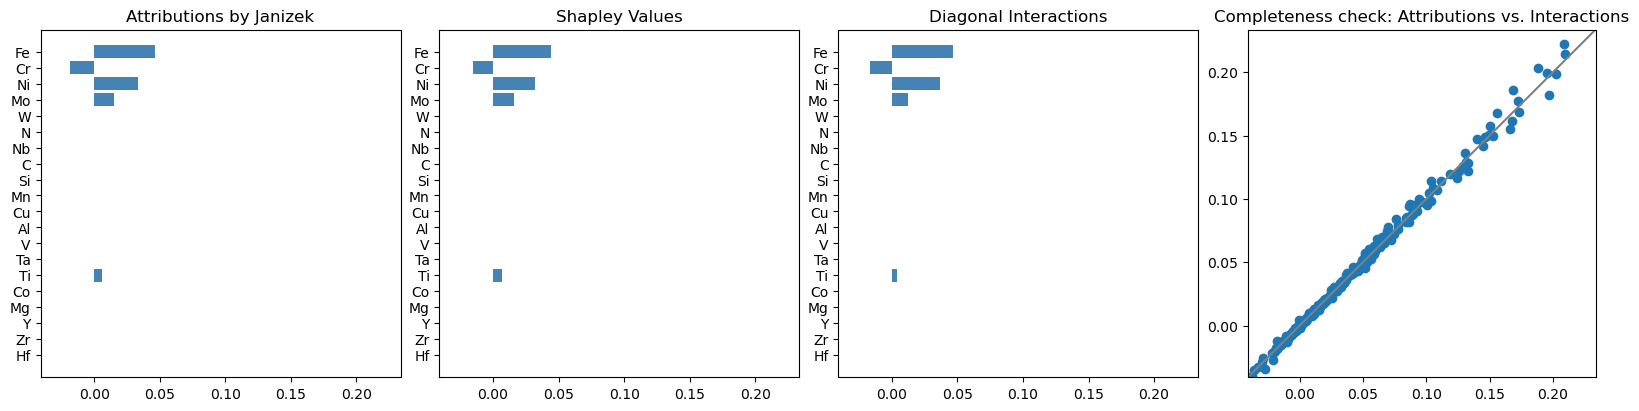

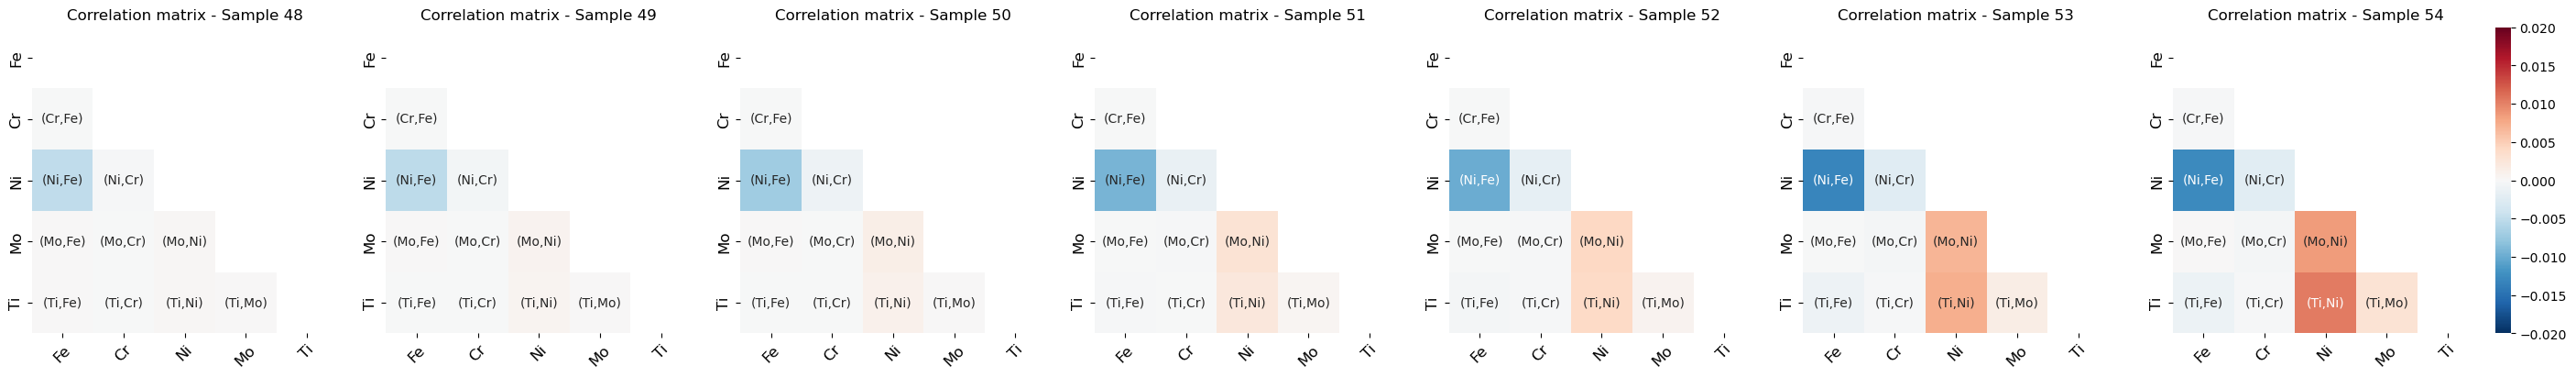

In [76]:
from utils.postprocessing_explainer import plot_shap_attributions_interactions, plot_interactions_heatmap

plot_shap_attributions_interactions(
    shap_values, attributions_values, interactions_values, 0, compo_column)

# sample_index = [58, 51, 43, 35, 27, 19, 12]
sample_index = [49, 50, 51, 52, 53, 54, 55]
# sample_index = [12]
sample_index = [x-1 for x in sample_index]
plot_interactions_heatmap(
    interactions_values, sample_index, compo_column,
    cmap='RdBu_r', vmin=-0.02, vmax=0.02)

#### Examing the full dataset


In [59]:
from utils.postprocessing_explainer import ModelExplainer

# Assuming ModelExplainer is either in this script or imported from another module
# shap doesn't work with MC dropout layer
k_folds, n_CVrepeats, mc_repeat = 6, 2, 1
repeat_val = k_folds * n_CVrepeats

data_lists = [X1_base_data, Y1_base_data, V1_base_data,
              X2_base_data, Z2_base_data, W2_base_data,
              X1_shap_data, Y1_shap_data, V1_shap_data,
              X2_shap_data, Z2_shap_data, W2_shap_data]

X1_base_list, Y1_base_list, V1_base_list, \
    X2_base_list, Z2_base_list, W2_base_list, \
    X1_shap_list, Y1_shap_list, V1_shap_list, \
    X2_shap_list, Z2_shap_list, W2_shap_list = [
        [data]*repeat_val for data in data_lists]

# Create instances of the ModelExplainer class for each model
NNH_predictor = ModelExplainer(model_path_bo, NNH_model_name, k_folds, n_CVrepeats, mc_repeat,
                               scalers["compo"], scalers["H_specific_testing"], scalers["specific_features"])

NNC_predictor = ModelExplainer(model_path_bo, NNC_model_name, k_folds, n_CVrepeats, mc_repeat,
                               scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"])

# Use the class instances to call the predict_norm_shap_bootstrap method
with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(NNH_predictor.predict_norm_shap_bootstrap,
                              X1_base_list, Y1_base_list, V1_base_list,
                              X1_shap_list, Y1_shap_list, V1_shap_list)

    future2 = executor.submit(NNC_predictor.predict_norm_shap_bootstrap,
                              X2_base_list, Z2_base_list, W2_base_list,
                              X2_shap_list, Z2_shap_list, W2_shap_list)

(H1_pred_norm_X1_base_stack, _, _,
 H1_pred_norm_X1_shap_stack, _, _,
 H1_shap_norm_X1_stack,
 H1_attributions_norm_X1_stack,
 H1_interactions_norm_X1_stack) = future1.result()

(C2_pred_norm_X2_base_stack, _, _,
 C2_pred_norm_X2_shap_stack, _, _,
 C2_shap_norm_X2_stack,
 C2_attributions_norm_X2_stack,
 C2_interactions_norm_X2_stack) = future2.result()

100%|██████████| 69/69 [05:54<00:00,  5.14s/it]


Sum of Shapley values for sample 0: 0.08354861627643309
Sum of attributions for sample 0: 0.0830166251398623
Sum of interactions for sample 0: 0.08723922846547794


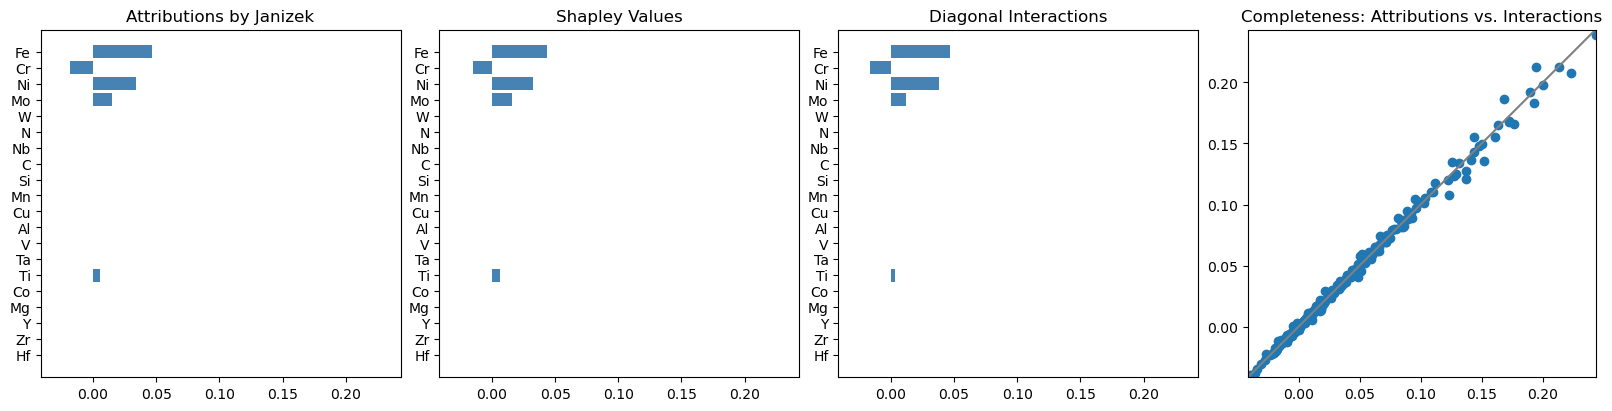

In [60]:
i_KFold, i_sample = 0, 0
plot_shap_attributions_interactions(
    H1_shap_norm_X1_stack[i_KFold],
    H1_attributions_norm_X1_stack[i_KFold],
    H1_interactions_norm_X1_stack[i_KFold],
    i_sample, compo_column)


#### Inverse transfrom feature attribution index


In [61]:
from utils.postprocessing_explainer import process_inverse_norm_explainer_data

(H1_pred_norm_X1_base_KFold_mean,
 H1_pred_norm_X1_shap_KFold_mean,
 H1_shap_norm_X1_KFold_mean,
 H1_attributions_norm_X1_KFold_mean,
 H1_interactions_norm_X1_KFold_mean,
 H1_pred_X1_base_KFold_mean,
 H1_pred_X1_shap_KFold_mean,
 H1_shap_X1_KFold_mean,
 H1_attributions_X1_KFold_mean,
 H1_interactions_X1_KFold_mean) = process_inverse_norm_explainer_data(H1_pred_norm_X1_base_stack, H1_pred_norm_X1_shap_stack,
                                                                      H1_shap_norm_X1_stack,
                                                                      H1_attributions_norm_X1_stack,
                                                                      H1_interactions_norm_X1_stack,
                                                                      scalers["H_output"])

(C2_pred_norm_X2_base_KFold_mean,
 C2_pred_norm_X2_shap_KFold_mean,
 C2_shap_norm_X2_KFold_mean,
 C2_attributions_norm_X2_KFold_mean,
 C2_interactions_norm_X2_KFold_mean,
 C2_pred_X2_base_KFold_mean,
 C2_pred_X2_shap_KFold_mean,
 C2_shap_X2_KFold_mean,
 C2_attributions_X2_KFold_mean,
 C2_interactions_X2_KFold_mean) = process_inverse_norm_explainer_data(C2_pred_norm_X2_base_stack, C2_pred_norm_X2_shap_stack,
                                                                      C2_shap_norm_X2_stack,
                                                                      C2_attributions_norm_X2_stack,
                                                                      C2_interactions_norm_X2_stack,
                                                                      scalers["C_output"])

# print(H1_pred_X1_shap_KFold_mean.shape)


Sum of Shapley values for sample 55: 331.5047607421875
Sum of attributions for sample 55: 332.47574148814584
Sum of interactions for sample 55: 330.49269247647163


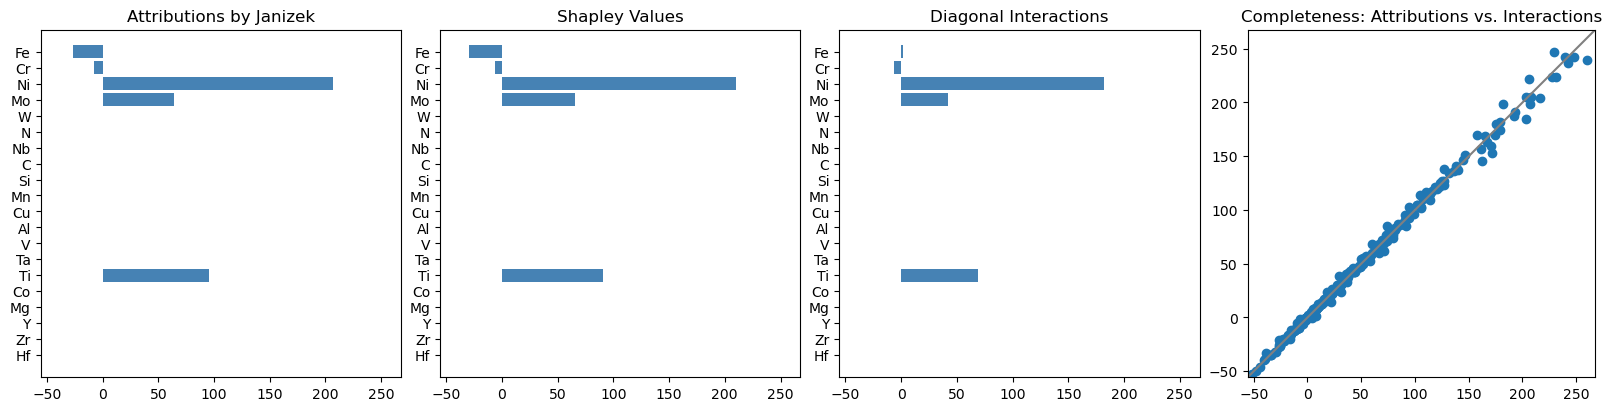

In [62]:
sample_index = 55
plot_shap_attributions_interactions(
    H1_shap_X1_KFold_mean,
    H1_attributions_X1_KFold_mean,
    H1_interactions_X1_KFold_mean,
    sample_index, compo_column)

#### Force plot of feature shapley/attributions


In [63]:
import shap
from utils.postprocessing_explainer import data_for_shap_force

# sample_index = [6, 15, 25, 35, 45, 55, 64]
sample_index = [57]
sample_index = [x-1 for x in sample_index]

A_baseline, B_shap_values, C_column_names = data_for_shap_force(X1_shap_data, Y1_shap_data, V1_shap_data,
                                                                compo_column, C_specific_testing_column, specific_features_sel_column,
                                                                H1_pred_X1_base_KFold_mean, H1_shap_X1_KFold_mean,
                                                                sample_index=sample_index)

shap.initjs()
shap.force_plot(
    A_baseline,
    B_shap_values,
    C_column_names,
    link='identity',
    matplotlib=False,
    figsize=(25, 3),
    text_rotation=45,
    contribution_threshold=0.001)


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,-11.910493,-0.525186,248.92374,83.292729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.725467,0.0,0.0,0.0,0.0,0.0


In [64]:
sample_index = [58, 51, 43, 35, 27, 19, 12]
# sample_index = [12]

sample_index = [x-1 for x in sample_index]
A_baseline, B_shap_values, C_column_names = data_for_shap_force(X2_shap_data, Z2_shap_data, W2_shap_data,
                                                                compo_column, C_specific_testing_column, specific_features_sel_column,
                                                                C2_pred_X2_base_KFold_mean, C2_shap_X2_KFold_mean,
                                                                sample_index=sample_index)
shap.initjs()
shap.force_plot(
    A_baseline,
    B_shap_values,
    C_column_names,
    link='identity',
    matplotlib=False,
    figsize=(25, 3),
    text_rotation=45,
    contribution_threshold=0.001)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,-58.513528,20.841828,66.421202,-14.512605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.786562,0.0,0.0,0.0,0.0,0.0
1,-49.803682,50.081944,67.663282,-11.501960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.501165,0.0,0.0,0.0,0.0,0.0
2,-29.881563,123.934378,88.569271,5.841530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.535987,0.0,0.0,0.0,0.0,0.0
3,2.380869,222.118085,114.583879,69.964475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.893214,0.0,0.0,0.0,0.0,0.0
4,65.522073,336.402692,153.230128,94.918693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.323813,0.0,0.0,0.0,0.0,0.0
5,42.248874,280.916940,146.513387,94.318458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.727012,0.0,0.0,0.0,0.0,0.0
6,7.948763,171.001512,160.177983,172.991535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.267414,0.0,0.0,0.0,0.0,0.0


#### plot feature interactions


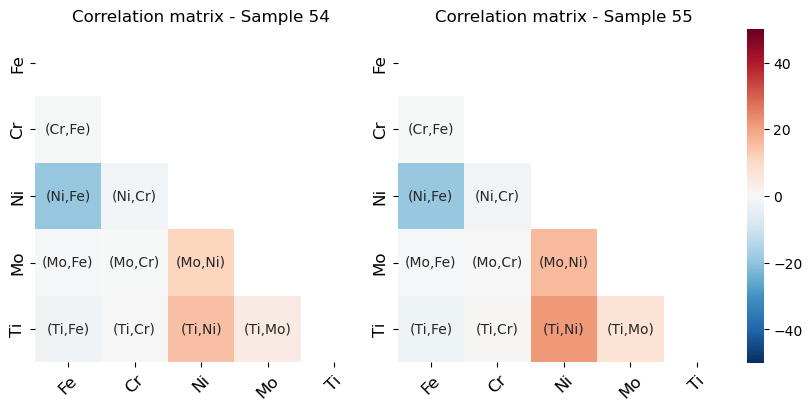

In [75]:
sample_index = [54, 55]
plot_interactions_heatmap(H1_interactions_X1_KFold_mean, sample_index,
                          compo_column,
                          cmap='RdBu_r', vmin=-50, vmax=50)

#### plot interaction/feature importance summary


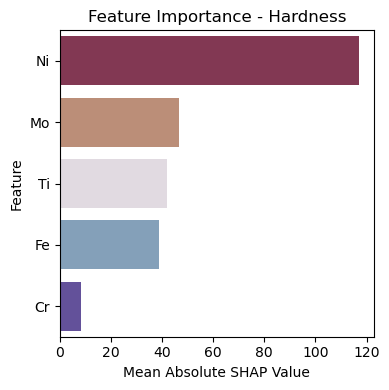

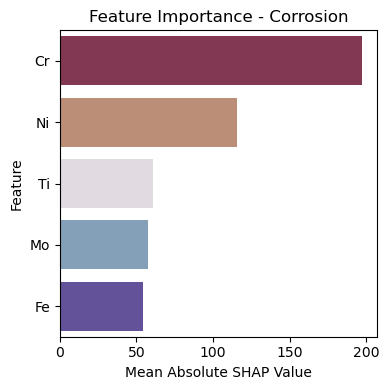

In [66]:
from utils.postprocessing_explainer import plot_shap_summary, plot_interactions_summary

plot_shap_summary(H1_shap_X1_KFold_mean, compo_column, is_abs=True,
                  title='Feature Importance - Hardness', figsize=(4, 4), palette='twilight_shifted_r')

plot_shap_summary(C2_shap_X2_KFold_mean, compo_column, is_abs=True,
                  title='Feature Importance - Corrosion', figsize=(4, 4), palette='twilight_shifted_r')


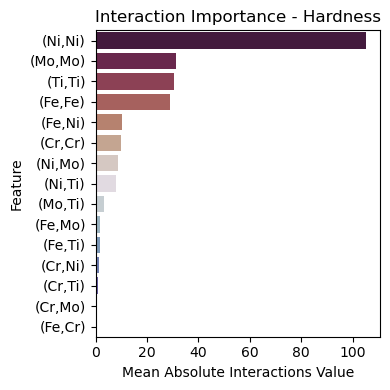

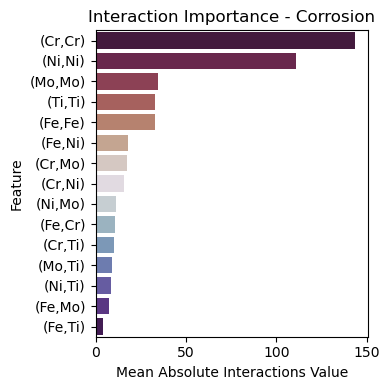

In [67]:
plot_interactions_summary(H1_interactions_X1_KFold_mean, compo_column, is_abs=True,
                          title='Interaction Importance - Hardness', figsize=(4, 4), palette='twilight_shifted_r')


plot_interactions_summary(C2_interactions_X2_KFold_mean, compo_column, is_abs=True,
                          title='Interaction Importance - Corrosion', figsize=(4, 4), palette='twilight_shifted_r')
